In [34]:
from bankingSystem import * 
from helperFunctions import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import warnings 
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%pylab inline 
pylab.rcParams['figure.figsize'] = (20, 20)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [58]:
# simulation and data collection
simulationSteps = 500
model = bankingSystem(banksFile="balanceSheetAnalysis/banksData_2022.csv", # csv file used to initialize the bank agents
                leverageRatio = 10.0,                                     # leverage ratio upper bound for all banks
                depositReserve = 0.20,                                     # capital reserve as a ratio of portfolio value
                num_borrowing= 20,                                        # number of borrowing request per bank per step
                sizeOfBorrowing = 1.0/3,                                      # size of borrowing as a ratio of equity capital
                num_banks=100,                                            # number of banks in the system 
                alpha = 0.5,                                              # portfolio recovery rate                           
                beta = 0.9,                                               # interbank loan recovery rate
                fedRate = 0.04,                                            # interest rate on borrowing   
                portfolioReturnRate = 0.10,                                # return rate on portfolio
                returnVolatiliy = 0.18,
                gammas = np.linspace(4.0,0.5,100).reshape(-1,1),
                returnCorrelation = np.diag(np.ones(100)),
                liquidityShockNum = 1,                                    # number of liquidity shocks per step      
                shockSize = 0.,                                          # size of the shock
                shockDuration =  [300, 305]) # duration of the shock
                
model.datacollector.collect(model)
for i in tqdm(range(simulationSteps)):
    model.simulate()
    
agent_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()

100%|██████████| 500/500 [00:57<00:00,  8.71it/s]


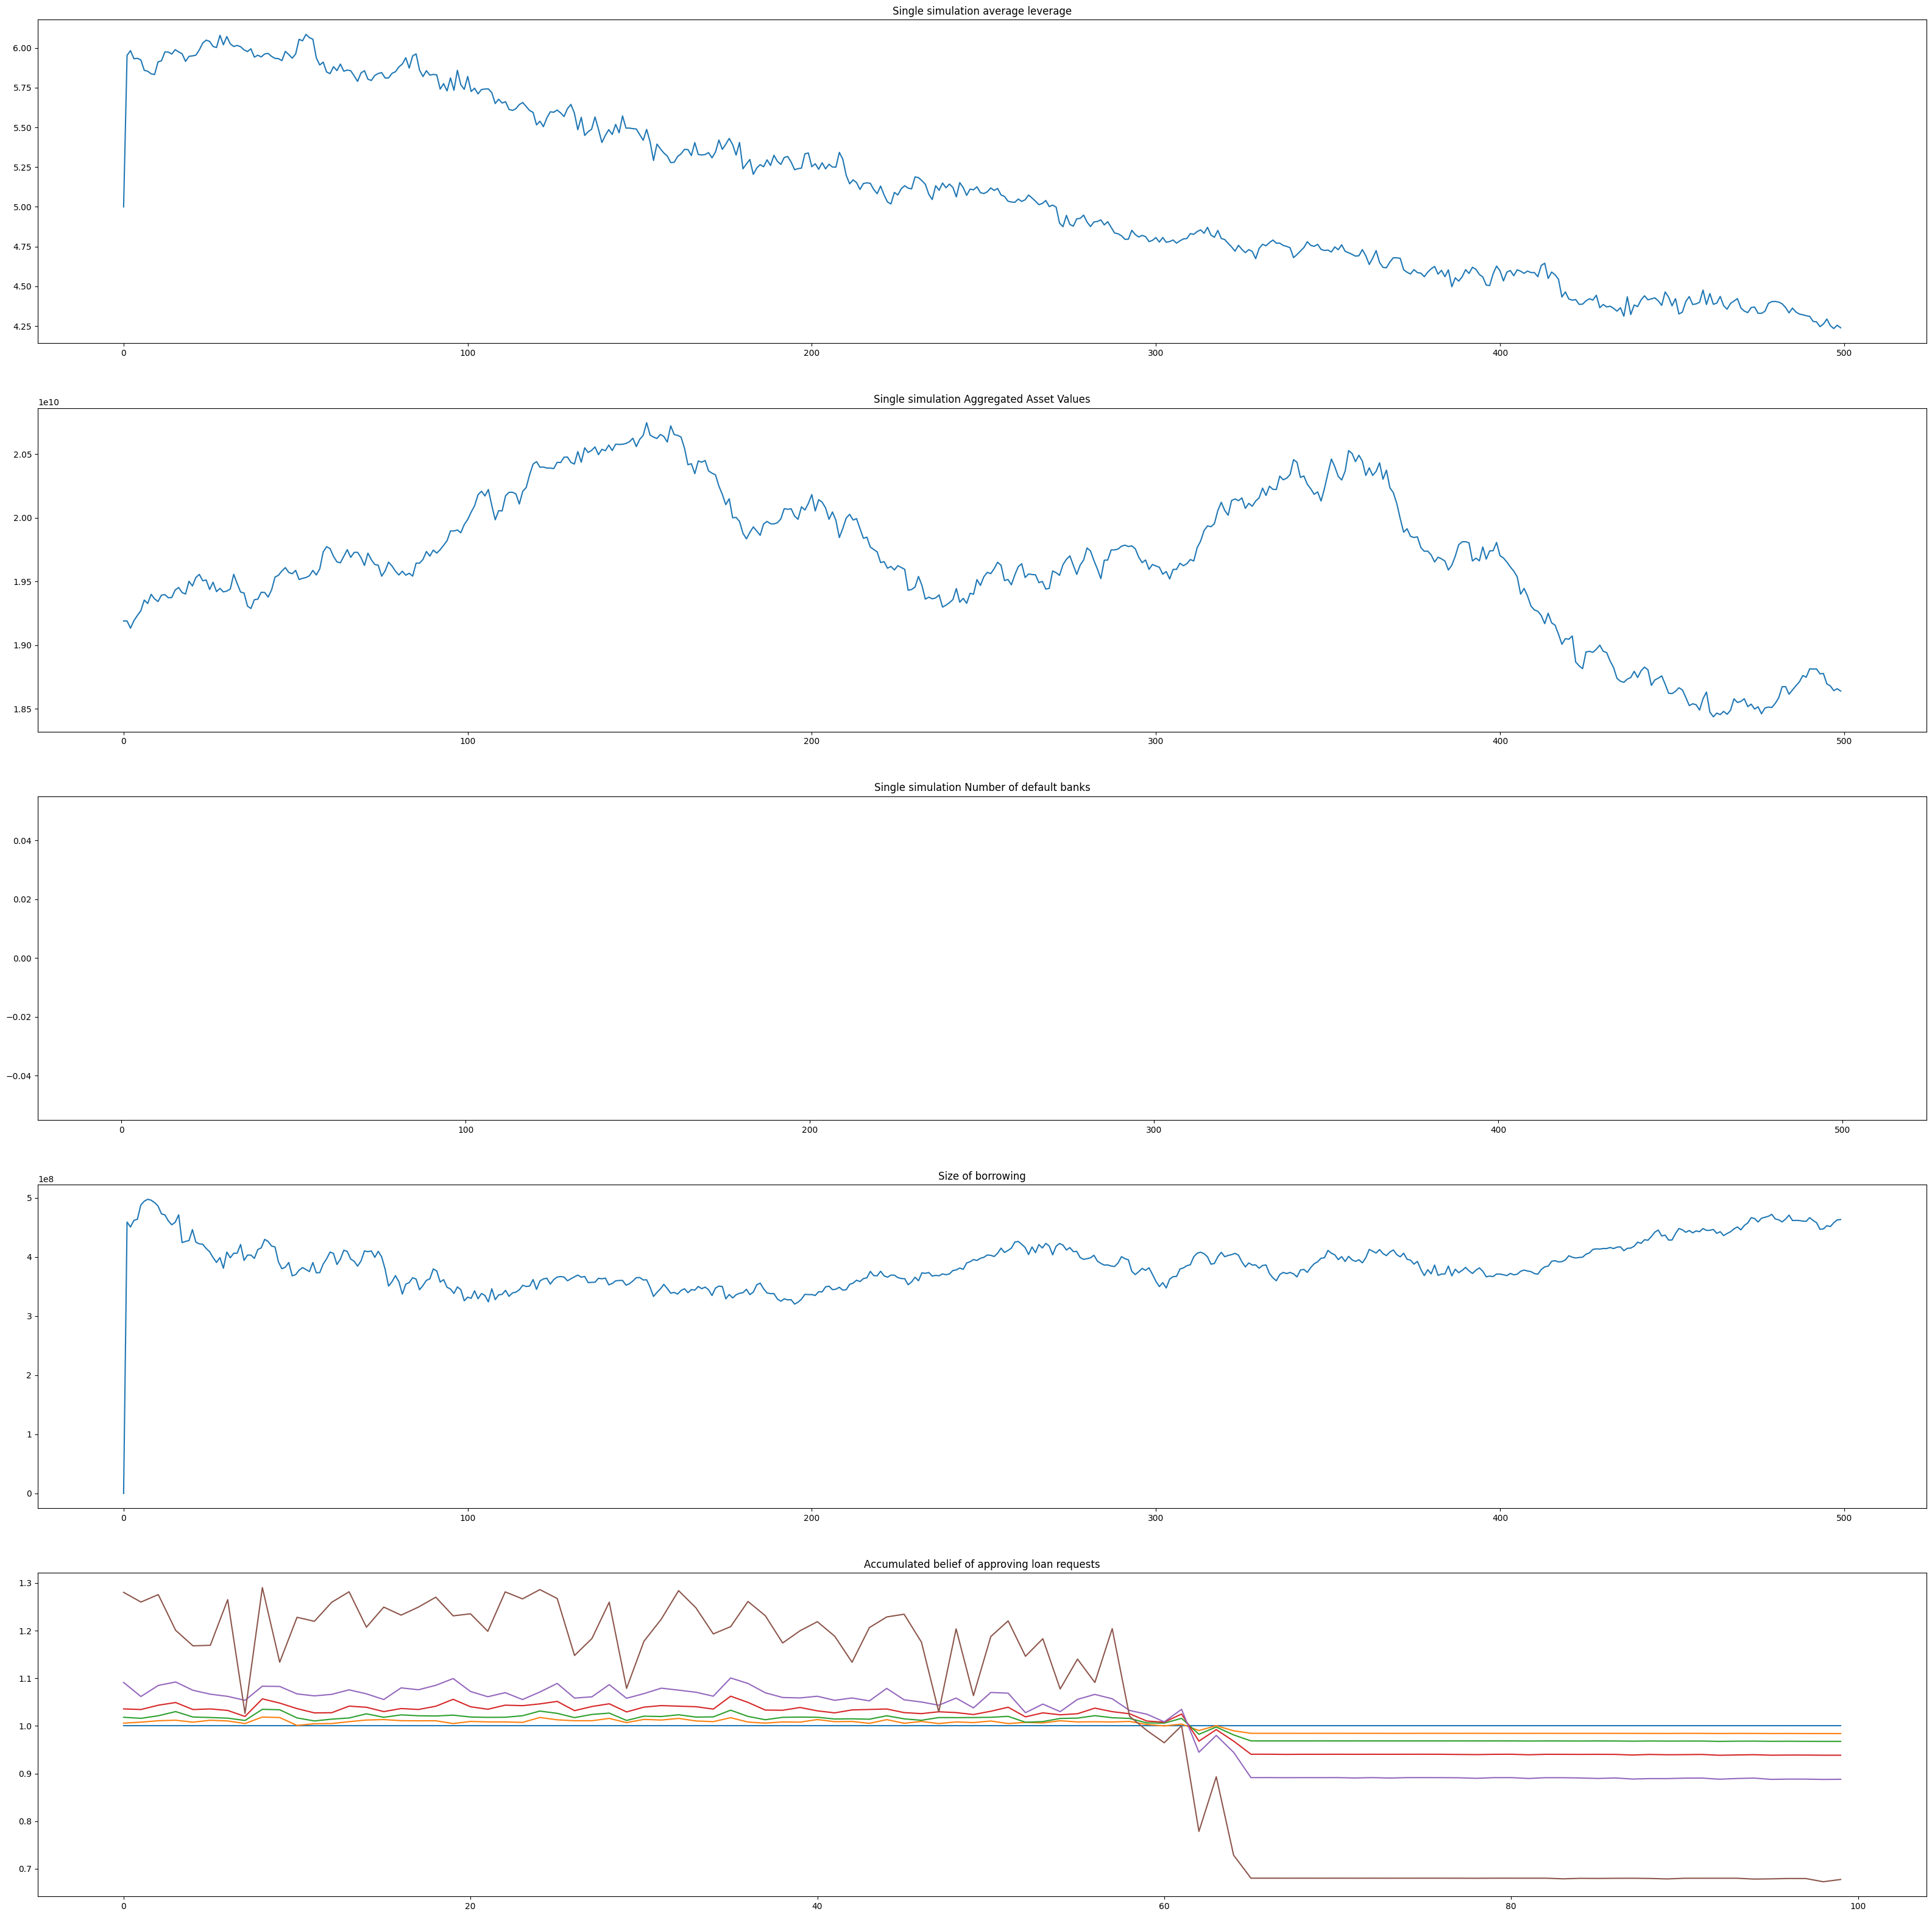

In [59]:
simulationMonitor(agent_data, model_data, simulationSteps)

In [ ]:
def run():
    # simulation and data collection
    simulationSteps = 500
    model = bankingSystem(banksFile="balanceSheetAnalysis/banksData_2022.csv", # csv file used to initialize the bank agents
                    leverageRatio = 15.0,                                     # leverage ratio upper bound for all banks
                    depositReserve = 0.20,                                     # capital reserve as a ratio of portfolio value
                    num_borrowing= 10,                                        # number of borrowing request per bank per step
                    sizeOfBorrowing = 1.0,                                      # size of borrowing as a ratio of equity capital
                    num_banks=100,                                            # number of banks in the system 
                    alpha = 0.,                                              # portfolio recovery rate                           
                    beta = 0.,                                               # interbank loan recovery rate
                    fedRate = 0.04,                                            # interest rate on borrowing   
                    portfolioReturnRate = 0.10,                                # return rate on portfolio
                    returnVolatiliy = 0.18,
                    gammas = np.ones((100,1))*1.7316+np.random.normal(0,0.1,(100,1)),
                    returnCorrelation = np.diag(np.ones(100)),
                    liquidityShockNum = 1,                                    # number of liquidity shocks per step      
                    shockSize = 0.,                                          # size of the shock
                    shockDuration =  [300, 305]) # duration of the shock
                    
    model.datacollector.collect(model)
    for i in tqdm(range(simulationSteps)):
        model.simulate()
        
    agent_data = model.datacollector.get_agent_vars_dataframe()
    model_data = model.datacollector.get_model_vars_dataframe()
    return model_data, agent_data, model

model_data_collection = []
agent_data_collection = []
model_collection = []
for _ in range(10):
    m, a, model = run()
    model_data_collection.append(m)
    agent_data_collection.append(a)
    model_collection.append(model)

100%|██████████| 500/500 [00:10<00:00, 47.29it/s]


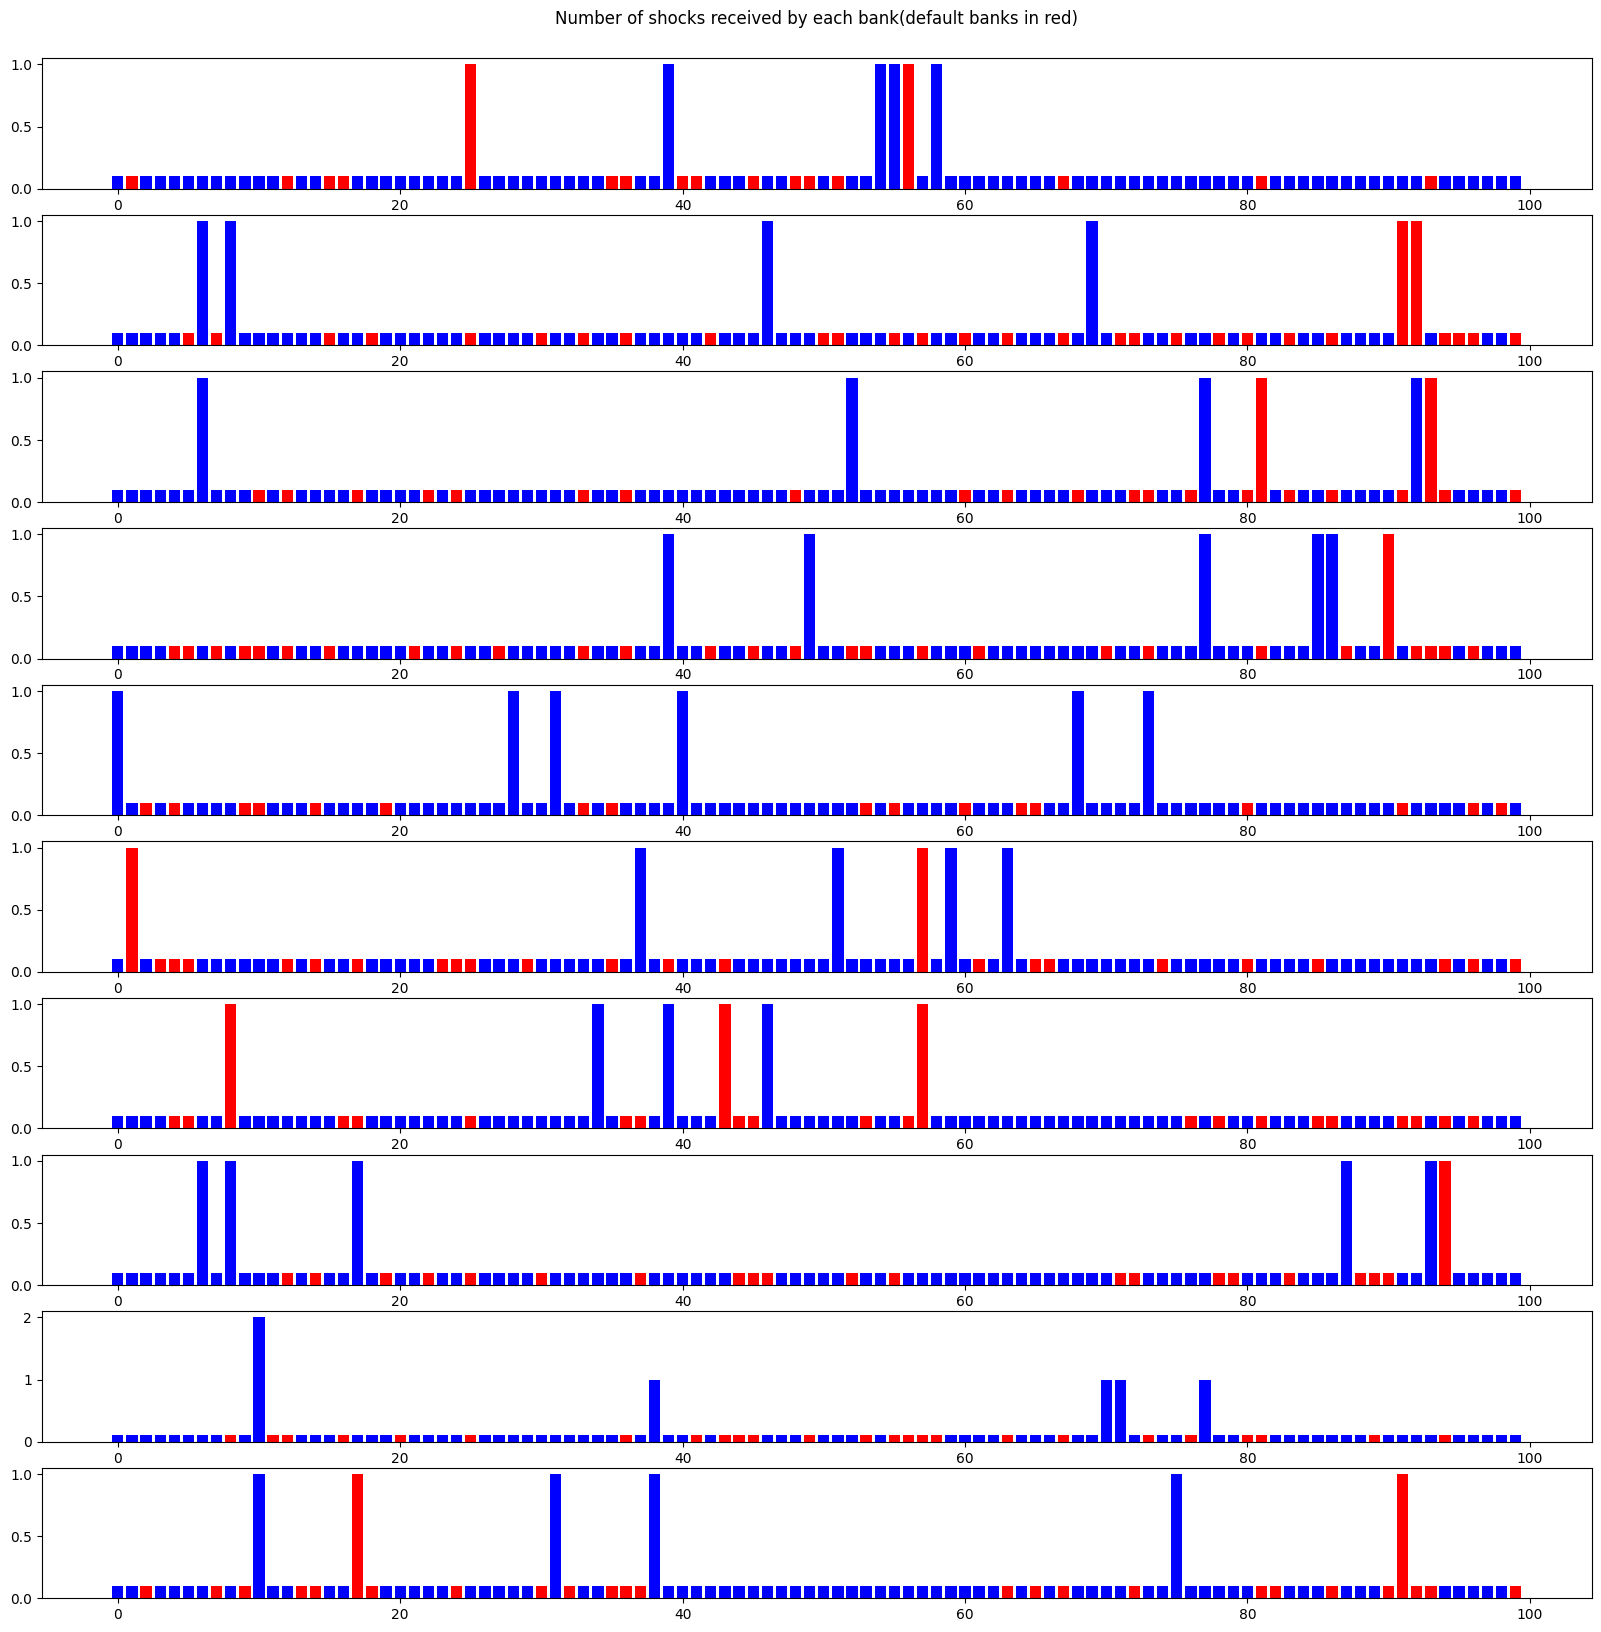

In [45]:
# shock analysis
simulationSteps=500
fig, axes = plt.subplots(nrows=10, ncols=1)
axes = axes.ravel()

plt.title("Number of shocks received by each bank(default banks in red)", y = 12)
for agent_data, model,j in zip(agent_data_collection, model_collection, range(10)):
    agents_df = agent_data.xs(simulationSteps, level="Step")
    defaults = agents_df[agents_df.Default ==True].index
    red_bars = defaults
    keyVals = [] 
    for k, v in model.shockedBanks.items():
        keyVals.append([k,v])
    
    for i in range(100):
        if i not in model.shockedBanks:
            keyVals.append([i,0.1])
    
    keyVals = np.array(keyVals)
    bar_colors = ['red' if i in red_bars else 'blue' for i in keyVals[:,0]]
    axes[j].bar(keyVals[:,0], keyVals[:,1],color=bar_colors)
plt.show()

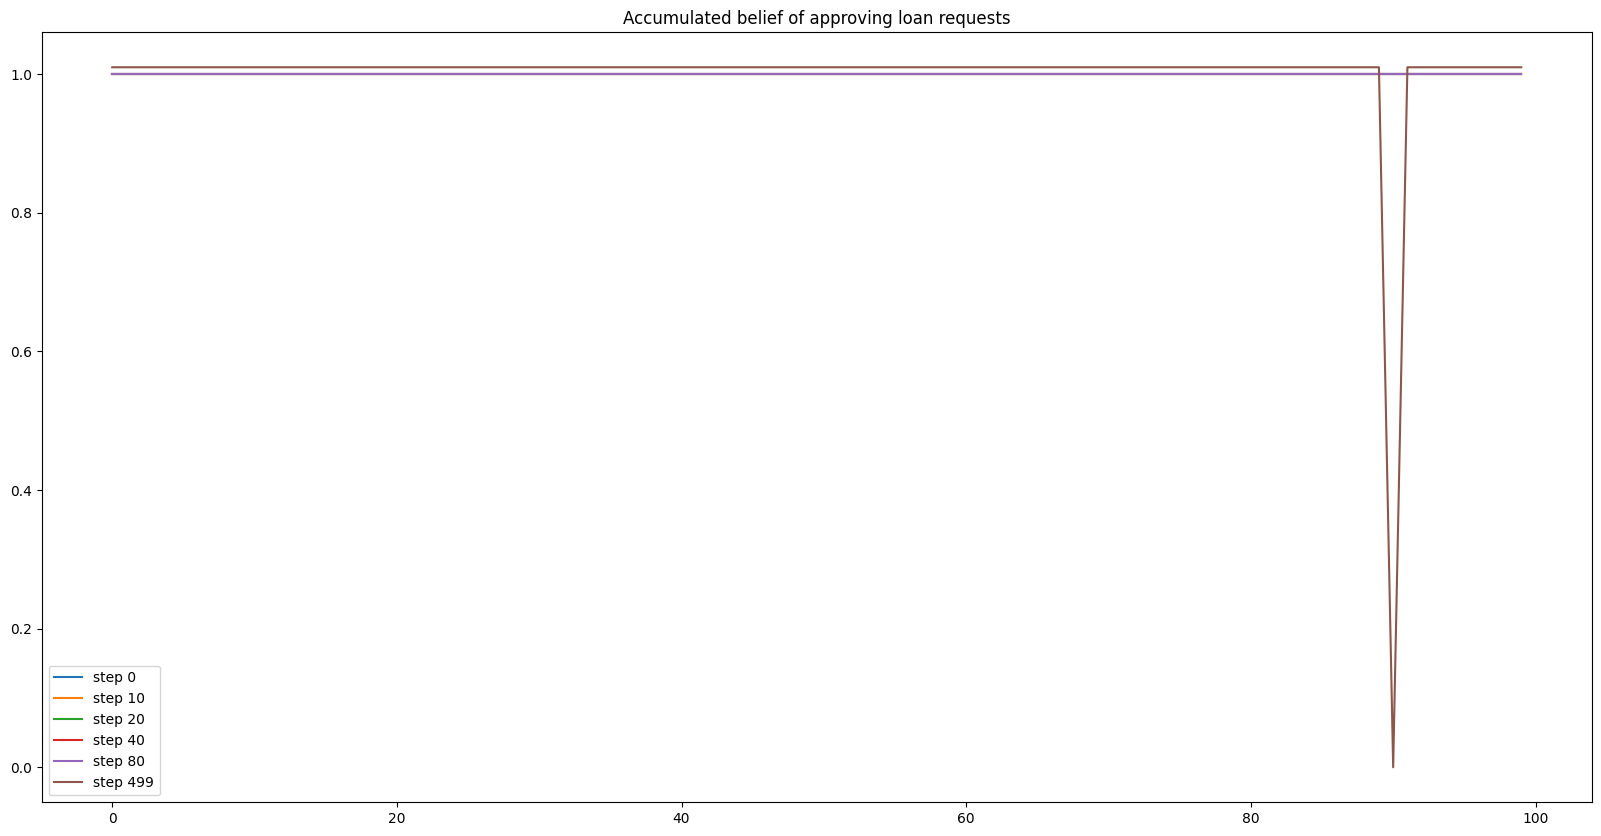

In [72]:
plt.figure(figsize=(20,10))
plt.title("Accumulated belief of approving loan requests")
for i in [0,10,20,40,80,499]:
    plt.plot(range(100),model_data["Trust Matrix"][i].sum(axis = 0), label = "step " + str(i))
plt.legend()

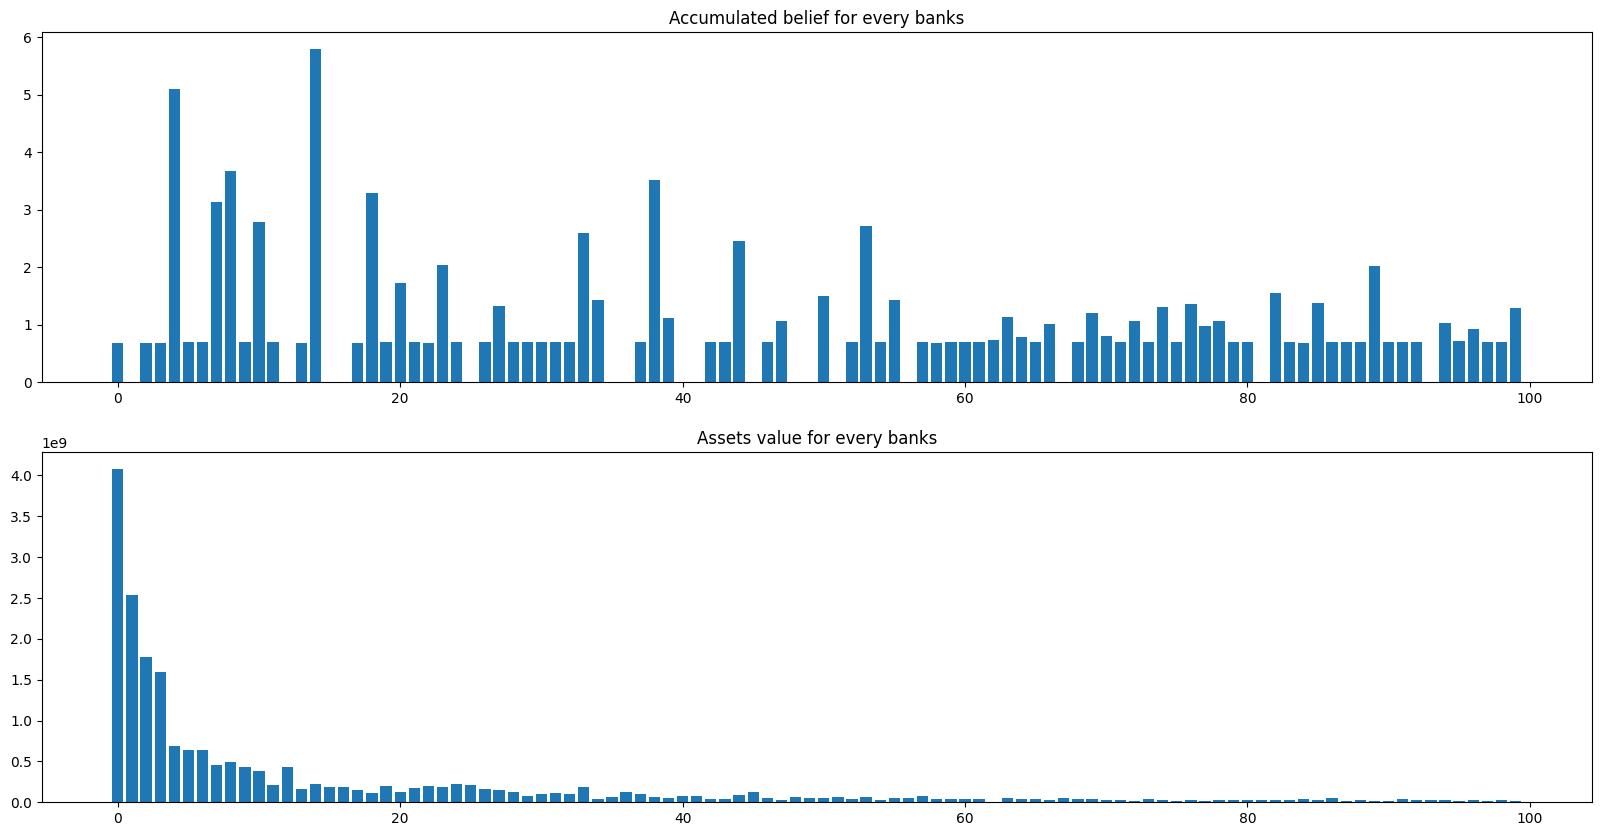

In [58]:
# bar chart of portfolio value
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(20, 10)
ax1.bar(range(model.N), model_data["Trust Matrix"][simulationSteps].sum(axis = 0))
ax1.set_title("Accumulated belief for every banks")
ax2.bar(range(model.N), agent_data.xs(simulationSteps, level="Step")["PortfolioValue"])
ax2.set_title("Assets value for every banks")
plt.show()